<a href="https://colab.research.google.com/github/keesterbrugge/rl_intro_sutton/blob/main/ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example 4.2: Jack’s Car Rental Jack manages two locations for a nationwide car
rental company. Each day, some number of customers arrive at each location to rent cars.
If Jack has a car available, he rents it out and is credited 10 by the national company.
If he is out of cars at that location, then the business is lost. Cars become available for
renting the day after they are returned. To help ensure that cars are available where
they are needed, Jack can move them between the two locations overnight, at a cost of
$2 per car moved. We assume that the number of cars requested and returned at each
location are Poisson random variables, meaning that the probability that the number is n is  n e  , where   is the expected number. Suppose   is 3 and 4 for rental requests at n!
the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a
maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be   = 0.9 and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight. Figure 4.2 shows the sequence of policies found by policy iteration starting from the policy that never moves any cars.

In [2]:
from scipy.stats import poisson
import numpy as np
import numba as nb
# poisson([1,3,4,5]).pmf(k=np.array([4, 5]).T)
# poisson.pmf(mu=np.array([3,4]),k=np.array([4, 5]), size=(2,2))

In [5]:
# def get_r(s,a):
#   reward_action = - 2 * abs(a)
#   s_after_action = np.clip(np.array(s) + np.array([-a, a]) a_min=0, a_max=20)
#   mor

In [6]:

def poisson_pmf(lam, k):
  return np.exp(-lam) * lam ** k  / np.math.factorial(k) 
poisson_pmf(3,2)

0.22404180765538775

In [7]:
def poisson_pmf(lam, k):
  return np.exp(-lam) * lam ** k  / np.math.factorial(k) 
poisson_pmf(3,2)

# @numba.jit(nopython=True)
# def trunc_poisson_jit(mu, k, k_max):
k_max = 3
[poisson_pmf(3, k=i) for i in range(k_max) ]

[0.049787068367863944, 0.14936120510359183, 0.22404180765538775]

In [8]:

def trunc_poisson(mu, k, k_max):  
    if k < k_max: 
      p = poisson.pmf(mu=3, k=k)
    elif (k == k_max):
      p = poisson.sf(mu=3, k = k-1)
    else:
      p = 0.0
    return p

def get_p_s_prime_1loc(cars_start, rental_req_lambda, car_returns_lambda):

  max_cars = 20
  p_s_prime_1loc = np.zeros(max_cars+1)

  for cars_rented_out in np.arange(cars_start+1):
    p_cars_rented_out = trunc_poisson(mu=rental_req_lambda, k=cars_rented_out, k_max=cars_start)

    cars_after_renting_out = cars_start - cars_rented_out
    max_new_cars = max_cars - cars_after_renting_out

    for cars_arrived in np.arange(max_new_cars+1):

      p_cars_arrived = trunc_poisson(mu=car_returns_lambda, k=cars_arrived, k_max=max_new_cars)
      cars_end = cars_after_renting_out + cars_arrived
      p_state_transition = p_cars_rented_out * p_cars_arrived
      p_s_prime_1loc[cars_end] += p_state_transition

  return p_s_prime_1loc

In [9]:
def get_prob_per_new_state(s, rental_request_lambdas, car_returns_lambdas):
  return np.outer(*[get_p_s_prime_1loc(s[i], rental_request_lambdas[i], car_returns_lambdas[i]) for i in [0, 1]])

get_prob_per_new_state((10,10), (3,4), (3,2)).sum()

1.0000000000000004

In [12]:
# gamma = 0.9
# max_cars=20
# V = np.zeros((max_cars+1,max_cars+1))
# (gamma*V*p_s_prime).sum()

In [13]:

def get_expected_R(s, rental_request_lambdas):
  expected_cars_rented_out = 0
  for cars_start, rental_req_lambda in zip(s, rental_request_lambdas):
    expected_cars_rented_out += np.array(
        [cars_rented_out * trunc_poisson(mu=rental_req_lambda, 
                                        k=cars_rented_out, 
                                        k_max=cars_start) 
        for cars_rented_out in np.arange(cars_start+1)]).sum()

    
  return 10 * expected_cars_rented_out

get_expected_R(s=(3,3), rental_request_lambdas=(4,3))

46.55749154067674

In [15]:
def get_s_after_action(s, action):
  return(tuple(np.clip(np.array(s) + np.array([-action, action]), a_min=0, a_max=20).astype('int'))
)

In [17]:
# morn_to_eve_state_trans_matrices = {}
# for s in np.ndindex(V.shape):
#   morn_to_eve_state_trans_matrices[s] = get_prob_per_new_state(s, 
#                                       rental_request_lambdas, 
#                                       car_return_lambdas)

In [18]:
np.min([3, 2])

2

In [22]:
def get_action_space(s):

  max_to_second = np.min([5, s[0]])
  max_to_first = np.min([5, s[1]])
  return np.arange(-max_to_first, max_to_second + 1)

get_action_space((2,1))

def get_action_R(a):
  return -2 * abs(a)

In [29]:
# %%time

# 1 init
V = np.random.uniform(size=(21,21))
A = np.arange(-5,6)
policy=np.zeros_like(V)
print(f"{V[:5,:5]=} \n\n {policy[:5,:5]=}")


transition_R = np.zeros_like(V)

rental_request_lambdas=(3,4)
car_return_lambdas = (3,2)
gamma = 0.9

# 2 
delta_theshold = 3

delta = delta_theshold + 1

# P_new_state = get_prob_per_new_state(s_after_action, 
#                                       rental_request_lambdas, 
#                                       car_return_lambdas)

morn_to_eve_state_trans_matrices = {}
expected_rental_Rs = {}
for s in np.ndindex(V.shape):
  morn_to_eve_state_trans_matrices[s] = get_prob_per_new_state(s, 
                                      rental_request_lambdas, 
                                      car_return_lambdas)
  

  expected_rental_Rs[s] = get_expected_R(s, rental_request_lambdas)

def q_s_a(s, action ):
    s_after_action = get_s_after_action(s, action)
    expected_rental_R = expected_rental_Rs[s_after_action]
    P_new_state = morn_to_eve_state_trans_matrices[s_after_action]
    expected_V_new_state = (V*P_new_state).sum()
    return expected_rental_R + get_action_R(action) + gamma * expected_V_new_state

# while delta >= delta_theshold:
def value_improvement(V, policy):
  delta = 100
  while delta > .5:
    delta = 0
    # for s in [(19,1)]:
    for s in np.random.permutation(list(np.ndindex(V.shape))):
      s = tuple(s)
      v = V[s]

      action = policy[s]
      # s_after_action = get_s_after_action(s, action)

      # expected_rental_R = expected_rental_Rs[s_after_action]
      # P_new_state = morn_to_eve_state_trans_matrices[s_after_action]

      # expected_V_new_state = (V*P_new_state).sum()
      #expected_rental_R + get_action_R(action) + gamma * expected_V_new_state

      # because deterministic
      V[s] =  q_s_a(s, action) 

      delta = max(delta, abs(v-V[s]))

    print(f"sanity: {delta=}")
  return V


print(f"{V[:8,:8]=} \n\n {policy[:8,:8]=}")


# 3
# while delta >= delta_theshold:
def policy_improvement(V, policy):
  policy_stable = False
  while policy_stable == False:
    changes = 0
    policy_stable = True
    for s in np.random.permutation(list(np.ndindex(V.shape))):
      s = tuple(s)
      old_a = policy[s]
      qs = {a : q_s_a(s, a) for a in get_action_space(s)}
      if qs[old_a] != max(qs.values()):
        policy_stable = False
        changes += 1 
        policy[s] = max(qs, key=qs.get)

    print(f"sanity: {policy_stable}, {changes=}")

  return policy

Vs = []
policies = []
V_i = V
policy_i = policy
for _ in range(7):
  V_i = value_improvement(V, policy)
  Vs.append(V_i)

  policy_i = policy_improvement(V, policy)
  policies.append(policy_i) 




# # 3
# # while delta >= delta_theshold:
# for _ in range(20):
#   changes = 0
#   policy_stable = True
#   for s in np.random.permutation(list(np.ndindex(V.shape))):
#     s = tuple(s)
#     old_action = policy[s]
#     s_after_action = get_s_morning_start(s, action)
#     old_actual_action = s_after_action[1] - s[1]
#     old_action_R = - 2 * abs(old_actual_action)
#     best_action = old_actual_action
#     best_V = V[s]
#     for alt_action in get_action_space(s):
#       alt_s_in_morning = get_s_morning_start(s, alt_action)
#       alt_actual_action = alt_s_in_morning[1] - s[1]
#       alt_V = -2 * abs(alt_actual_action) + transition_R[alt_s_in_morning] + gamma*V[alt_s_in_morning]
#       if alt_V > best_V:
#         policy_stable = False
#         best_V = alt_V
#         policy[s] = alt_actual_action
#         changes += 1

#   print(f"sanity: {policy_stable}, {changes=}")

      


print(f"{V[:8,:8]=} \n\n {policy[:8,:8]=}")


V[:5,:5]=array([[0.21093642, 0.47876359, 0.99243672, 0.58512817, 0.03686681],
       [0.45650216, 0.17053343, 0.22827881, 0.07430245, 0.90013811],
       [0.40246837, 0.24059556, 0.7571531 , 0.67754104, 0.59155799],
       [0.36728773, 0.00981785, 0.77991614, 0.4383739 , 0.48584147],
       [0.52337219, 0.00099545, 0.12958017, 0.74419159, 0.60275071]]) 

 policy[:5,:5]=array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
V[:8,:8]=array([[0.21093642, 0.47876359, 0.99243672, 0.58512817, 0.03686681,
        0.21317332, 0.69601088, 0.45384895],
       [0.45650216, 0.17053343, 0.22827881, 0.07430245, 0.90013811,
        0.5039734 , 0.20814477, 0.76583485],
       [0.40246837, 0.24059556, 0.7571531 , 0.67754104, 0.59155799,
        0.63571112, 0.25112749, 0.83836765],
       [0.36728773, 0.00981785, 0.77991614, 0.4383739 , 0.48584147,
        0.6936336 , 0.63953989, 0.63902809],
       [0.52337219, 0

In [30]:
import matplotlib.pyplot as plt

In [31]:
policies[-1]

array([[ 0.,  0.,  0.,  0., -1., -1., -2., -2., -3., -3., -4., -4., -4.,
        -4., -5., -5., -5., -5., -5., -5., -5.],
       [ 0.,  0.,  0.,  0.,  0., -1., -1., -2., -2., -3., -3., -3., -3.,
        -4., -4., -4., -4., -4., -4., -4., -5.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1., -1., -2., -2., -2., -2., -3.,
        -3., -3., -3., -3., -3., -3., -4., -4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -2., -2.,
        -2., -2., -2., -2., -2., -3., -3., -3.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1.,
        -1., -1., -1., -1., -2., -2., -2., -2.],
       [ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1., -1., -1., -1., -1.],
       [ 2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  2.,  

In [42]:
policies[-1].shape
X.shape

(22, 22)

In [43]:
x = np.arange(21)
y = np.arange(21)
# y = np.linspace(0, stop=20, step=1)

X, Y = np.meshgrid(x, y)
X



array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18,

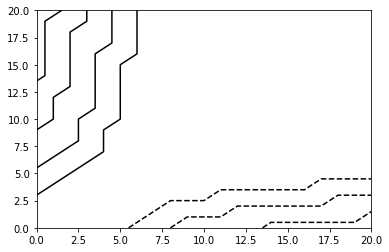

In [44]:
plt.contour(X, Y, policies[-1], colors='black');


In [50]:
np.array([-4 for cars in s if cars > 20])

array([], dtype=float64)

In [ ]:
a = np.ndindex(V.shape)
a

In [25]:
stats = dict(a = 3, b = 5, c =4)
max(stats, key=stats.get)


'b'

## version 2 of jack's

V[:5,:5]=array([[0.83081426, 0.50248787, 0.93042356, 0.43056093, 0.68426734],
       [0.03928846, 0.41336848, 0.10208633, 0.02367386, 0.7968245 ],
       [0.62200981, 0.21718419, 0.71420778, 0.57387551, 0.21114921],
       [0.71179398, 0.53907853, 0.69231792, 0.69514204, 0.53421065],
       [0.27260061, 0.40723225, 0.55441348, 0.97564615, 0.41474484]]) 

 policy[:5,:5]=array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
V[:8,:8]=array([[0.83081426, 0.50248787, 0.93042356, 0.43056093, 0.68426734,
        0.21769914, 0.71210126, 0.25795974],
       [0.03928846, 0.41336848, 0.10208633, 0.02367386, 0.7968245 ,
        0.17352977, 0.99165525, 0.40617372],
       [0.62200981, 0.21718419, 0.71420778, 0.57387551, 0.21114921,
        0.85598216, 0.65136277, 0.21476709],
       [0.71179398, 0.53907853, 0.69231792, 0.69514204, 0.53421065,
        0.43897852, 0.02761455, 0.32574313],
       [0.27260061, 0

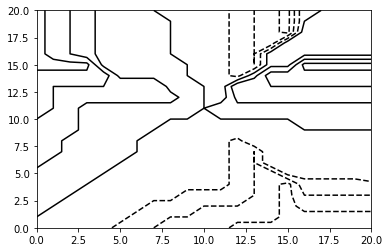

In [52]:
# %%time

# 1 init
V = np.random.uniform(size=(21,21))
A = np.arange(-5,6)
policy=np.zeros_like(V)
print(f"{V[:5,:5]=} \n\n {policy[:5,:5]=}")


transition_R = np.zeros_like(V)

rental_request_lambdas=(3,4)
car_return_lambdas = (3,2)
gamma = 0.9

# 2 
delta_theshold = 3

delta = delta_theshold + 1

# P_new_state = get_prob_per_new_state(s_after_action, 
#                                       rental_request_lambdas, 
#                                       car_return_lambdas)

morn_to_eve_state_trans_matrices = {}
expected_rental_Rs = {}
for s in np.ndindex(V.shape):
  morn_to_eve_state_trans_matrices[s] = get_prob_per_new_state(s, 
                                      rental_request_lambdas, 
                                      car_return_lambdas)
  

  expected_rental_Rs[s] = get_expected_R(s, rental_request_lambdas)

def q_s_a_2(s, action ):
    s_after_action = get_s_after_action(s, action)
    second_parking_lot_R = np.array([-4 for cars in s_after_action if cars > 10]).sum()
    expected_rental_R = expected_rental_Rs[s_after_action]
    P_new_state = morn_to_eve_state_trans_matrices[s_after_action]
    expected_V_new_state = (V*P_new_state).sum()
    if action < 0:
      action_R = 2*action
    else:
      action_R = -2 * max(0, action -1)
    return expected_rental_R + action_R + second_parking_lot_R + gamma * expected_V_new_state

# while delta >= delta_theshold:
def value_improvement(V, policy):
  delta = 100
  while delta > .5:
    delta = 0
    # for s in [(19,1)]:
    for s in np.random.permutation(list(np.ndindex(V.shape))):
      s = tuple(s)
      v = V[s]

      action = policy[s]
      # s_after_action = get_s_after_action(s, action)

      # expected_rental_R = expected_rental_Rs[s_after_action]
      # P_new_state = morn_to_eve_state_trans_matrices[s_after_action]

      # expected_V_new_state = (V*P_new_state).sum()
      #expected_rental_R + get_action_R(action) + gamma * expected_V_new_state

      # because deterministic
      V[s] =  q_s_a_2(s, action) 

      delta = max(delta, abs(v-V[s]))

    print(f"sanity: {delta=}")
  return V


print(f"{V[:8,:8]=} \n\n {policy[:8,:8]=}")


# 3
# while delta >= delta_theshold:
def policy_improvement(V, policy):
  policy_stable = False
  while policy_stable == False:
    changes = 0
    policy_stable = True
    for s in np.random.permutation(list(np.ndindex(V.shape))):
      s = tuple(s)
      old_a = policy[s]
      qs = {a : q_s_a_2(s, a) for a in get_action_space(s)}
      if qs[old_a] != max(qs.values()):
        policy_stable = False
        changes += 1 
        policy[s] = max(qs, key=qs.get)

    print(f"sanity: {policy_stable}, {changes=}")

  return policy

Vs = []
policies = []
V_i = V
policy_i = policy
for _ in range(7):
  V_i = value_improvement(V, policy)
  Vs.append(V_i)

  policy_i = policy_improvement(V, policy)
  policies.append(policy_i) 






plt.contour(X, Y, policies[-1], colors='black');
      





## 4.9

In [7]:
list(np.ndindex(V.shape))

[(0,),
 (1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (11,),
 (12,),
 (13,),
 (14,),
 (15,),
 (16,),
 (17,),
 (18,),
 (19,),
 (20,),
 (21,),
 (22,),
 (23,),
 (24,),
 (25,),
 (26,),
 (27,),
 (28,),
 (29,),
 (30,),
 (31,),
 (32,),
 (33,),
 (34,),
 (35,),
 (36,),
 (37,),
 (38,),
 (39,),
 (40,),
 (41,),
 (42,),
 (43,),
 (44,),
 (45,),
 (46,),
 (47,),
 (48,),
 (49,),
 (50,),
 (51,),
 (52,),
 (53,),
 (54,),
 (55,),
 (56,),
 (57,),
 (58,),
 (59,),
 (60,),
 (61,),
 (62,),
 (63,),
 (64,),
 (65,),
 (66,),
 (67,),
 (68,),
 (69,),
 (70,),
 (71,),
 (72,),
 (73,),
 (74,),
 (75,),
 (76,),
 (77,),
 (78,),
 (79,),
 (80,),
 (81,),
 (82,),
 (83,),
 (84,),
 (85,),
 (86,),
 (87,),
 (88,),
 (89,),
 (90,),
 (91,),
 (92,),
 (93,),
 (94,),
 (95,),
 (96,),
 (97,),
 (98,),
 (99,),
 (100,)]

In [20]:
get_action_space(99)

array([0, 1])

In [42]:
p_head = 0.4

# def get_gamblers_problem(p_head=0.4):
S = np.arange(101)
V = np.random.uniform(size=S.shape)
V[0] = 0
V[100] = 1

def get_action_space(s):
  return np.arange(1,min(s,100-s)+1)

def q(s,a, V):
  return p_head * V[s + a] + (1-p_head)*V[s-a]

theta = 0.1
for _ in range(200):
  delta = 0
  # for s in np.random.permutation(list(np.ndindex(V.shape))):
  for s in np.random.permutation(np.arange(1,100)):
    v = V[s]
    qs = [q(s,a, V) for a in get_action_space(s)]
    V[s] = max(qs)
    delta = max(delta, abs(v-V[s]))
  # print(f"{delta=}")
print(V[50])
V

0.4


array([0.        , 0.00217126, 0.00542815, 0.00956529, 0.01357037,
       0.01921324, 0.02391323, 0.02827066, 0.0335699 , 0.04035955,
       0.04769137, 0.05346112, 0.05953261, 0.06562124, 0.07067666,
       0.07688342, 0.08392476, 0.09155278, 0.09988888, 0.1091297 ,
       0.11793628, 0.12621303, 0.13365279, 0.14064547, 0.14883153,
       0.16      , 0.16385218, 0.16963046, 0.17645587, 0.18407615,
       0.19181476, 0.20113966, 0.2098119 , 0.21885737, 0.22783804,
       0.23797103, 0.24972219, 0.26108876, 0.27282424, 0.28298823,
       0.29484071, 0.30476237, 0.31553258, 0.32504821, 0.33413199,
       0.34319344, 0.35156579, 0.36131866, 0.37093948, 0.38324729,
       0.4       , 0.40397859, 0.40963046, 0.41645587, 0.42407615,
       0.43220854, 0.44113966, 0.4498119 , 0.45885737, 0.46832276,
       0.4795369 , 0.48972219, 0.50108876, 0.51282424, 0.52298823,
       0.53484071, 0.54714343, 0.5561241 , 0.5695951 , 0.57972809,
       0.59492757, 0.60667873, 0.62430547, 0.63567204, 0.65272

In [120]:
from numba import njit
p_head = 0.4

@njit
def q(s,a, V, p_head):
  return p_head * V[s + a] + (1-p_head)*V[s-a]

@njit
def get_gamblers_problem(p_head=0.4):



  S = np.arange(101)
  # V = np.random.uniform(size=S.shape)
  V = np.array([np.random.random() for _ in np.arange(101)])
  V[0] = 0
  V[100] = 1

  def get_action_space(s):
    return np.arange(1,min(s,100-s)+1)



  theta = 0.1
  for _ in range(300000):
    delta = 0
    # for s in np.random.permutation(list(np.ndindex(V.shape))):
    for s in np.random.permutation(np.arange(1,100)):
      v = V[s]
      qs = [q(s,a, V, p_head) for a in get_action_space(s)]
      V[s] = max(qs)
      delta = max(delta, abs(v-V[s]))
    # print(f"{delta=}")

  policy = np.zeros_like(S)
  for s in np.arange(1,100):
    qs = np.array([q(s,a,V, p_head) for a in get_action_space(s)])
    policy[s] = np.argmax(qs)

  # policy = np.array([q(s, a, V) for s in np.arange(1,100)])
  return V, policy, 

V2, policy2 = get_gamblers_problem(.01)

In [121]:
# q(50, 50, V)
V2[50]

0.01

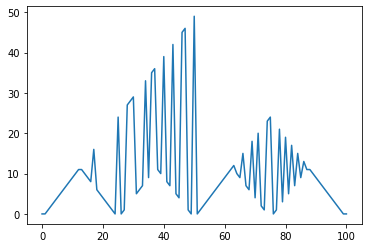

In [122]:
import matplotlib.pyplot as plt

plt.plot(policy2)



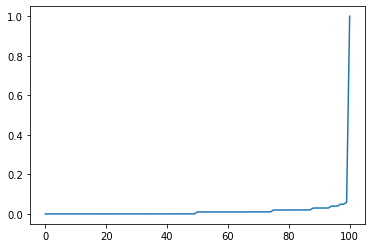

In [123]:
plt.plot(V2)

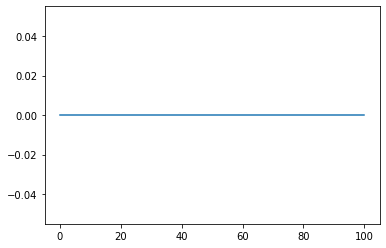

In [124]:
V3, policy3 = get_gamblers_problem(.51)

plt.plot(policy3)

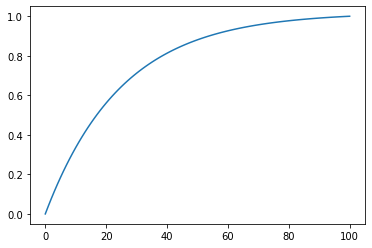

In [125]:
plt.plot(V3)